In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
import numpy
import scipy
import matplotlib as mpl
import matplotlib.dates as mpd
import pylab as plt
import datetime
import os,sys
#
import subprocess
import requests
import tarfile
import shutil
#
import urllib
import contextlib
# import urllib.request as request
# from contextlib import closing
#
import re
#
import json
import netCDF4
#
import AM4py

### AM4 runtime scripting: Development, examples, and templates

This notebook contains development work, examples, and templates to script AM4 simulations in Python. The basic strategy is to write a Python script to manage preliminary setup tasks, ie setting up working directories, copying data, assessing the restart status, and then (possibly) submit a simple batch script to run the large MPI job.

Tasks delegated to the Python parent script include:

- Do we have a working directory? Does it contain an INPUT folder?
- If not, copy INPUT data from a designated source (which can take a long, long time).
- Configure the batch scritp and `.nml` configuration to:
    - Use the correct `layout` formats
    - Request the correct number of processors
    - Make any configuratioon changes, from a base template
    - Other stuff too...
- Manage restarts

The advantages of this approach are:

1. Python is generally considered a more versatile and easy to use scripting language than any shell language.
2. To that point, most of these projects still come with `csh` or `tcsh` scripts, which are often simply not supported by newer OSs, including RedHat 7.x (it might be nominally available, but 1) might not be supported by admins (ie, LMOD will not work), and 2) it can in many cases just plain not run correctly. Accordingly, it is often necessary to translate any standard or provided scripts to `bash` anyway. We hope that, with these tools as a starting place, it will be easier to skip straight to Python.
3. Shell scripting often does not directly support very simple logic, that can be very helpful when managing large, complex runs -- particularly with checkpointing. For example, floating point math is not directly supported in `bash`.
4. Some preliminary operations, for example acquiring or copying input data, can be extremely cumbersome (it's a lot of data!); this approach allows these steps to be accomplished by a single-process setup script before the large MPI job is submitted. This will help to maintain friendships with your colleagues and sysadmins.
5. Permits flexibility, more complex scripts, for example running in small checkpointed steps, to better utilize shared resources, and (possibly) saving the incremental output.



In [3]:
def netcdf_summary(fin_name):
    with netCDF4.Dataset(fin_name, 'r') as fin:
        print('** dimensions: ', fin.dimensions)
        print('** variables.: ', fin.variables.keys())
        #
        for ky,v in fin.variables.items():
            print('** {}: {}'.format(ky, numpy.shape(v)))
        #
        #
        #print('** bl: ', fin['bl'][10, 10:20])
#         for ky in ['species','bl', 'blv', 'br', 'bsw', 'bwood', 'bliving', 'status'] :
#             fg = plt.figure(figsize=(12,2))
#             plt.imshow(fin[ky])
#             plt.title('var: {}'.format(ky))

### AM4py Example

- OPTIONAL:
    - Define big-picture (ie, multiple runs) job
    - Evaluate `work_dir` data to determine next actions (ie, did the previous job run, are we finished, etc.)
- Instantiate an `AM4_batch_scripter` object
    - It will evaluate whether the input data exist; if not, it will go get it.
- Modify the NML configuration and export a working NML
- Write a batch file to run AM4
- Submit that script


In [4]:
print(os.environ['HOME'])
xx=subprocess.run('hostname', capture_output=True)
print('** ', xx.stdout)

#print('** ', xx.content)

/home/myoder96
**  b'cees-tool-8\n'


In [5]:
#
#input_data_path = os.path.join(os.environ['HOME'], 'Codes', 'AM4_data2', 'AM4_run')
#work_dir = os.path.join(os.environ['HOME'], 'Codes', 'AM4', 'workdir_empty')

input_data_path = os.path.join(os.environ['SCRATCH'], 'AM4', 'AM4_run')
work_dir = os.path.join(os.environ['SCRATCH'], 'AM4', 'workdir_empty')

job_name = 'AM4_dev'
batch_job_name = os.path.join(work_dir, 'AM4_batch_example.bs')
#
#print('*** input_data_path: ', input_data_path)
#
ABS = AM4py.AM4_batch_scripter(input_data_path=input_data_path, work_dir=work_dir,
                               job_name='AM4_dev', batch_out=batch_job_name )
#
print('*** ABS variables:')
for key,val in ABS.__dict__.items():
    print('{}: {}'.format(key,val))
#

#zz = ABS.get_input_data(verbose=True)
zz = ABS.get_empty_workdir(verbose=True)


my_configs = {'coupler_nml':{'days':2, 'months':0}, 'fv_core_nml':{'npx':97, 'npy':97, 'npz':33}}
my_nml = ABS.make_NML(nml_template='input_yoder_v101.nml', nml_configs=[my_configs],
                      nml_out=os.path.join(ABS.work_dir, 'input.nml') )
# NML_from_nml('input_yoder_v101.nml')

#my_nml = NML_from_nml('input_yoder_v101.nml')
print('** my_nml[fv_core_nml]:' )
print('** ', my_nml['fv_core_nml'])
#print(my_nml.keys())

print('** batch_out: ', ABS.batch_out)
#
ABS.write_batch_script()
#

proc_out = subprocess.run('sbatch {}'.format(ABS.batch_out).split(), check=True, capture_output=True)
print('** proc_out.stdout: {}\n\n'.format(proc_out.stdout))
print('** proc_out.stderr: {}\n\n'.format(proc_out.stderr))

*** ABS variables:
batch_out: /scratch/myoder96/AM4/workdir_empty/AM4_batch_example.bs
work_dir: /scratch/myoder96/AM4/workdir_empty
mpi_exec: {'exec': 'mpirun', 'ntasks': '-np ', 'cpu_per_task': '--cpus-per-proc '}
input_data_path: /scratch/myoder96/AM4/AM4_run
input_data_tar: /scratch/myoder96/AM4/AM4_run.tar.gz
input_data_url: ftp://nomads.gfdl.noaa.gov/users/Ming.Zhao/AM4Documentation/GFDL-AM4.0/inputData/AM4_run.tar.gz
nml_template: nml_input_template.nml
modules: ['intel/19', 'openmpi_3/', 'gfdl_am4/']
diag_table_src: diag_table_v101
field_table_src: field_table_v101
data_table_src: data_table_v101
force_copy_input: 0
do_tar: 0
hpc_config: {'cpus_per_node': 24, 'cpu_slots': 2, 'cpu_make': 'intel', 'cpu_gen': 'haswell', 'mem_per_node': 64, 'modules': ['intel/19', 'openmpi_3/', 'gfdl_am4/']}
npes_atmos: 48
nthreads_atmos: 1
npes_ocean: 0
job_name: AM4_dev
sbatch_options_str: 
copy_timeout: 6000
verbse: 0
cwd: /scratch/myoder96/AM4/AM4_runtime
root_path: /scratch/myoder96/AM4
defaul

In [10]:
print('** ', ABS.batch_out)
print('*** ', 'abcd=efg\n'.split('='), '**')

**  am4_batch.sh
***  ['abcd', 'efg\n'] **


In [5]:
print(ABS.mpi_exec)

print('MPI_COMMAND={} {}{} {}{} ${{EXECUTABLE\}}'.format(ABS.mpi_exec['exec'],
                                                            ABS.mpi_exec['ntasks'], ABS.n_tasks,
                                                            ABS.mpi_exec['cpu_per_task'], ABS.n_threads))

{'exec': 'mpirun', 'ntasks': '--np ', 'cpu_per_task': '-d '}
MPI_COMMAND=mpirun --np 48 -d 1 ${EXECUTABLE\}


In [ ]:
# simplified syntax to capture both stdout and stderr (to separate outputs?). NOTE: this syntax has been
#. a moving target
#sp_output = subprocess.run('ls -lh'.split(chr(32)), check=True, capture_output=True)
#
# pipe stdout and stderr to the same output
sp_output = subprocess.run('ls -lh /Users/myoder96/Codes/AM4_data2/AM4_run/'.split(chr(32)), check=True,
                           stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
#
print('** sp_output: \n', sp_output)
# for rw in sp_output.stdout.decode().split('\n'):
#     print*('** ', rw)
print('** ** stdout: \n', sp_output.stdout.decode())
for rw in sp_output.stdout.decode().split('\n'):
    print('** ', rw)

In [ ]:
NML_test = NML_from_nml('input_yoder_v101.nml')
#

# for ky,vl in JJ.nml_dict.items():
#     print('** {}: {}'.format(ky,vl))


for ky in ['coupler_nml','coupler_nml', 'vegn_data_nml', 'simple_sulfate_nml' ]:
    print('*** {}:{}\n'.format(ky, NML_test[ky]))

In [ ]:
print(NML_test['aerosolrad_package_nml']['sulfate_indices'])

### Working NML example.

- Start with a standard template
- Compute layouts for an MPI configuration
- Modify layout variables (in internal JSON/dict)
- Export working input.nml

In [ ]:
        
n_tasks = 48
n_threads = 1
#
layouts_1 = get_layouts(n_tasks)
layouts_2 = get_layouts(n_tasks = n_tasks/6)
#
layout_io_1 = get_io_layouts(layouts_1[0])
layout_io_2 = get_io_layouts(layouts_2[0])
#
print('** Layouts_1: ', layouts_1)
print('** Layouts_2: ', layouts_2)
#
print('** Layouts_io_1: ', layout_io_1)
print('** Layouts_io_2: ', layout_io_2)
#
my_nml = NML_from_nml(input_nml='input_yoder_v101.nml')

In [ ]:
print('*** ', my_nml.keys())

In [ ]:
layout_1=layouts_1[0]
layout_2=layouts_2[0]
#
layout_io = layout_io_1[0]

#
# print out layouts, as they are imported:
for grp in ('fv_core_nml', 'land_model_nml','ocean_model_nml', 'ice_model_nml'):
    print('** {}::layout: {}'.format(grp, my_nml[grp]['layout']))
    print('** {}::io_layout: {}'.format(grp, my_nml[grp]['layout']))
    print('\n')

In [ ]:
print('** ', 48%6)
print('** ', 48%5)

In [ ]:
#print('** ', my_nml['fv_core_nml']['layout'])
#
for grp in ('fv_core_nml', 'land_model_nml'):
    my_nml.assign(grp, 'layout', ','.join([str(x) for x in layout_2]))
    my_nml.assign(grp, 'io_layout', ','.join([str(x) for x in layout_io]))
    print('** {}:: {}, {}'.format(grp, my_nml[grp]['layout'], my_nml[grp]['io_layout']))
#
for grp in ('ocean_model_nml', 'ice_model_nml'):
    my_nml.assign(grp, 'layout', ','.join([str(x) for x in layout_1]))
    my_nml.assign(grp, 'io_layout', ','.join([str(x) for x in layout_io]))
    print('** {}:: {}, {}'.format(grp, my_nml[grp]['layout'], my_nml[grp]['io_layout']))
#
for ky,vl in [('npx',193), ('npy', 193), ('npz', 50)]:
    my_nml.assign('fv_core_nml', ky, vl)
#
for ky,vl in [('co2_ceiling', 4800.0E-06), ('time_varying_co2', '.true.'), ('co2_base_value',348.0E-06),
            ('co2_floor', 100.0E-06), ('c02_data_source', 'namelist') ]:
    # NOTE: we want to allow new assignment:
    my_nml['radiative_gases_nml'][ky] = vl
print('*** radiative_gases: ', my_nml['radiative_gases_nml'])

In [ ]:
for ky,vl in my_nml['radiative_gases_nml'].items():
    print('** {}:: {}'.format(ky, vl))
print('\n\n')
#
for ky,vl in my_nml['fv_core_nml'].items():
    print('** {}:: {}'.format(ky, vl))

In [ ]:
my_nml.json_to_nml(nml_out='my_output.nml', json_in=my_nml)

In [ ]:
print(','.join([str(x) for x in [1,2,3]]))

** dimensions:  OrderedDict([('lon', <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 96
), ('lat', <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 96
), ('tile', <class 'netCDF4._netCDF4.Dimension'>: name = 'tile', size = 14
), ('tile_index', <class 'netCDF4._netCDF4.Dimension'>: name = 'tile_index', size = 8305
), ('cohort', <class 'netCDF4._netCDF4.Dimension'>: name = 'cohort', size = 1
), ('cohort_index', <class 'netCDF4._netCDF4.Dimension'>: name = 'cohort_index', size = 8305
), ('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 365
)])
** variables.:  odict_keys(['lon', 'lat', 'tile', 'tile_index', 'cohort', 'cohort_index', 'time', 'species', 'bl', 'blv', 'br', 'bsw', 'bwood', 'bliving', 'status'])
** lon: (96,)
** lat: (96,)
** tile: (14,)
** tile_index: (8305,)
** cohort: (1,)
** cohort_index: (8305,)
** time: (365,)
** species: (365, 8305)
** bl: (365, 8305)
** blv: (365, 8305)
** br: (365, 8305)
** bsw: (365, 8305)
** bwood: 

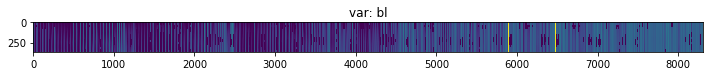

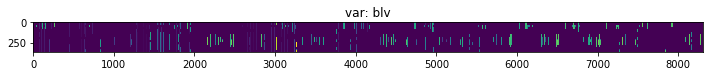

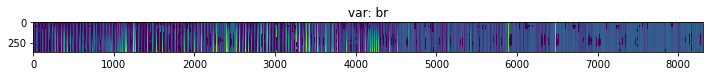

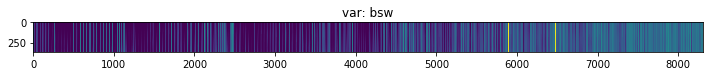

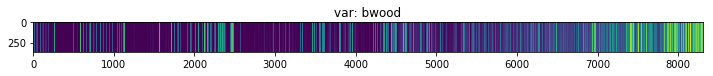

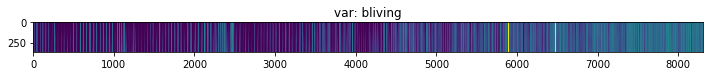

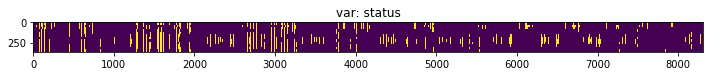

In [59]:
fin_name=os.path.join(os.environ['HOME'], 'Codes', 'AM4_runtime', 'workdir2', 'INPUT', '19810101.static_veg_out.tile4.nc')
with netCDF4.Dataset(fin_name, 'r') as fin:
    print('** dimensions: ', fin.dimensions)
    print('** variables.: ', fin.variables.keys())
    #
    for ky,v in fin.variables.items():
        print('** {}: {}'.format(ky, numpy.shape(v)))
    #
    #
    #print('** bl: ', fin['bl'][10, 10:20])
    for ky in ['bl', 'blv', 'br', 'bsw', 'bwood', 'bliving', 'status'] :
        fg = plt.figure(figsize=(12,2))
        plt.imshow(fin[ky])
        plt.title('var: {}'.format(ky))
    #print('** tile_index: ', fin['tile_index'][0:10])
    print('** time: ', fin['time'][:])
    
    

In [70]:
fn = 'cns_co2_0_HITRAN2012_630700_495lyr.nc'
fn = 'C96_mosaic_tile6Xocean_mosaic_tile1.nc'
fn = 'tracerIC.19800101.v2.nc'
fin_name=os.path.join(os.environ['HOME'], 'Codes', 'AM4_runtime', 
                      'workdir2', 'INPUT', fn)
# fin_name=os.path.join(os.environ['SCRATCH'], 'AM4', 
#                       'workdir3', 'INPUT', fn)
#
with netCDF4.Dataset(fin_name, 'r') as fin:
    print('** dimensions: ', fin.dimensions)
    #print('** variables.: ', fin.variables.keys())
    #
    if 'time' in fin.variables.keys():
        print('** time: ', fin['time'][:])
    for ky,v in fin.variables.items():
        print('** {}: {}'.format(ky, numpy.shape(v)))
                      
                      

** dimensions:  OrderedDict([('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 1
), ('pfull', <class 'netCDF4._netCDF4.Dimension'>: name = 'pfull', size = 48
), ('lat', <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 90
), ('lon', <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 144
), ('phalf', <class 'netCDF4._netCDF4.Dimension'>: name = 'phalf', size = 49
)])
** time:  [1.]
** clo: (1, 48, 90, 144)
** bro: (1, 48, 90, 144)
** no2: (1, 48, 90, 144)
** time: (1,)
** lon: (144,)
** lat: (90,)
** pfull: (48,)
** sphum: (1, 48, 90, 144)
** liq_wat: (1, 48, 90, 144)
** ice_wat: (1, 48, 90, 144)
** cld_amt: (1, 48, 90, 144)
** hno3: (1, 48, 90, 144)
** n2o5: (1, 48, 90, 144)
** h2o2: (1, 48, 90, 144)
** hcl: (1, 48, 90, 144)
** hocl: (1, 48, 90, 144)
** clono2: (1, 48, 90, 144)
** h2co: (1, 48, 90, 144)
** oy: (1, 48, 90, 144)
** hobr: (1, 48, 90, 144)
** hno4: (1, 48, 90, 144)
** hbr: (1, 48, 90, 144)
** brono2: (1, 48, 90, 144)
** ch3oo

** dimensions:  {'lon': <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 96, 'lat': <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 96, 'tile': <class 'netCDF4._netCDF4.Dimension'>: name = 'tile', size = 14, 'tile_index': <class 'netCDF4._netCDF4.Dimension'>: name = 'tile_index', size = 28649, 'cohort': <class 'netCDF4._netCDF4.Dimension'>: name = 'cohort', size = 1, 'cohort_index': <class 'netCDF4._netCDF4.Dimension'>: name = 'cohort_index', size = 28649, 'time': <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 365}
** variables.:  dict_keys(['lon', 'lat', 'tile', 'tile_index', 'cohort', 'cohort_index', 'time', 'species', 'bl', 'blv', 'br', 'bsw', 'bwood', 'bliving', 'status'])
** lon: (96,)
** lat: (96,)
** tile: (14,)
** tile_index: (28649,)
** cohort: (1,)
** cohort_index: (28649,)
** time: (365,)
** species: (365, 28649)
** bl: (365, 28649)
** blv: (365, 28649)
** br: (365, 28649)
** bsw: (365, 28649)
** bwood: (365, 28649)
** bliving: (

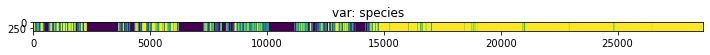

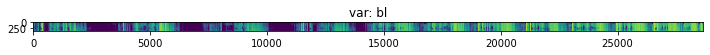

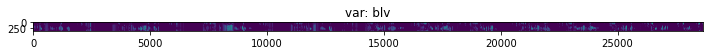

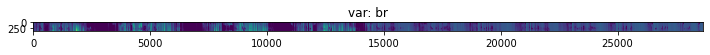

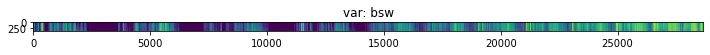

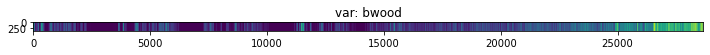

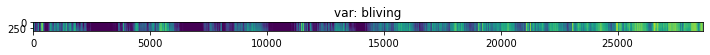

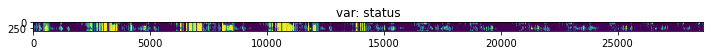

In [6]:
#fin_name=os.path.join(os.environ['HOME'], 'Codes', 'AM4_runtime', 'workdir2', 'INPUT', '19810101.static_veg_out.tile1.nc')
fin_name='/scratch/myoder96/AM4/workdir3/INPUT/19810101.static_veg_out.tile1.nc'

with netCDF4.Dataset(fin_name, 'r') as fin:
    print('** dimensions: ', fin.dimensions)
    print('** variables.: ', fin.variables.keys())
    #
    for ky,v in fin.variables.items():
        print('** {}: {}'.format(ky, numpy.shape(v)))
    #
    #
    #print('** bl: ', fin['bl'][10, 10:20])
    for ky in ['species','bl', 'blv', 'br', 'bsw', 'bwood', 'bliving', 'status'] :
        fg = plt.figure(figsize=(12,2))
        plt.imshow(fin[ky])
        plt.title('var: {}'.format(ky))
    #print('** tile_index: ', fin['tile_index'][0:10])
    print('** time: ', fin['time'][:])
    

In [15]:
fin_path =  '/scratch/myoder96/AM4/workdir3'
#fin_name = '/scratch/myoder96/AM4/workdir3/19790101.atmos_4xdaily.tile1.nc.0000'
fin_name = os.path.join('fin_path', '19790101.atmos_4xdaily.tile1.nc.0000' )

for fn in ('19790101.atmos_4xdaily.tile1.nc.0000', '19790101.atmos_4xdaily.tile1.nc.0001',
          '19790101.atmos_4xdaily.tile1.nc.0002', '19790101.atmos_4xdaily.tile1.nc.0003',
          'INPUT/cns_co2_300_HITRAN2012_900990_495lyr.nc'):
    #
    print('\n\nfname: {}'.format(fn))
    fin_name=os.path.join(fin_path, fn)
    xx = netcdf_summary(fin_name)
    with netCDF4.Dataset(fin_name, 'r') as fin:
        print('** time: {}'.format(fin['time'][:]))




fname: 19790101.atmos_4xdaily.tile1.nc.0000
** dimensions:  {'grid_xt': <class 'netCDF4._netCDF4.Dimension'>: name = 'grid_xt', size = 96, 'grid_yt': <class 'netCDF4._netCDF4.Dimension'>: name = 'grid_yt', size = 24, 'time': <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 8}
** variables.:  dict_keys(['grid_xt', 'grid_yt', 'time', 'vort850', 'tm', 'u_ref', 'v_ref', 'slp'])
** grid_xt: (96,)
** grid_yt: (24,)
** time: (8,)
** vort850: (8, 24, 96)
** tm: (8, 24, 96)
** u_ref: (8, 24, 96)
** v_ref: (8, 24, 96)
** slp: (8, 24, 96)
** time: [0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]


fname: 19790101.atmos_4xdaily.tile1.nc.0001
** dimensions:  {'grid_xt': <class 'netCDF4._netCDF4.Dimension'>: name = 'grid_xt', size = 96, 'grid_yt': <class 'netCDF4._netCDF4.Dimension'>: name = 'grid_yt', size = 24, 'time': <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 8}
** variables.:  dict_keys(['grid_xt', 'grid_yt', 'time', 'vort850', 'tm', 'u_ref', 'v_re

IndexError: time not found in /

In [8]:
fin_path =  '/scratch/myoder96/AM4/workdir3/RESTART'
#fin_name = '/scratch/myoder96/AM4/workdir3/19790101.atmos_4xdaily.tile1.nc.0000'
#fin_name = os.path.join('fin_path', '19790101.atmos_4xdaily.tile1.nc.0000' )

for fn in ('atmos_coupled.res.nc', 'atmos_coupled.res.tile1.nc.0001', 'physics_driver.res.nc',
           'fv_core.res.nc', 'cg_drag.res.nc'):
    #
    print('\n\nfname: {}'.format(fn))
    fin_name=os.path.join(fin_path, fn)
    xx = netcdf_summary(fin_name)
    with netCDF4.Dataset(fin_name, 'r') as fin:
        print('** * time: {}'.format(fin['Time'][:]))





fname: atmos_coupled.res.nc
** dimensions:  {'Time': <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'Time', size = 1}
** variables.:  dict_keys(['Time', 'glon_bnd', 'glat_bnd', 'dt'])
** Time: (1,)
** glon_bnd: (1,)
** glat_bnd: (1,)
** dt: (1,)
** * time: [1.]


fname: atmos_coupled.res.tile1.nc.0001
** dimensions:  {'xaxis_1': <class 'netCDF4._netCDF4.Dimension'>: name = 'xaxis_1', size = 96, 'yaxis_1': <class 'netCDF4._netCDF4.Dimension'>: name = 'yaxis_1', size = 24, 'Time': <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'Time', size = 1}
** variables.:  dict_keys(['xaxis_1', 'yaxis_1', 'Time', 'lprec', 'fprec', 'gust'])
** xaxis_1: (96,)
** yaxis_1: (24,)
** Time: (1,)
** lprec: (1, 24, 96)
** fprec: (1, 24, 96)
** gust: (1, 24, 96)
** * time: [1.]


fname: physics_driver.res.nc
** dimensions:  {'Time': <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'Time', size = 1}
** variables.:  dict_keys(['Time', 'vers', 'doing_strat', 'doing_edt', 'doing_entra

In [13]:
coupler_res={}
fname_coupler = '/scratch/myoder96/AM4/workdir3/RESTART/coupler.res'
fname_coupler = '/scratch/myoder96/AM4/workdir3/INPUT/coupler.res'


with open(fname_coupler, 'r') as fin:
    coupler_res['cal_type'] = fin.readline().split()[0]
    for rw in fin:
        if rw.startswith('\n'):
            continue
        #
        #rws = rw.split()
        coupler_res['curr_date'] = ','.join(rw.split()[0:6])
    #
#
print('*** ', coupler_res)
#
print('** **: ', ABS.get_restart_current_date('/scratch/myoder96/AM4/workdir3'))


ERROR: no coupler_path
** **:  1979,1,1,0,0,0


In [12]:
ABS.work_dir

'/scratch/myoder96/AM4/workdir_empty'

In [9]:
print('** **: ', ABS.get_restart_current_date('/scratch/myoder96/AM4/workdir3'))

** **:  1979,1,5,0,0,0
